# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.10KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

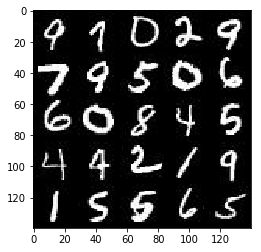

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

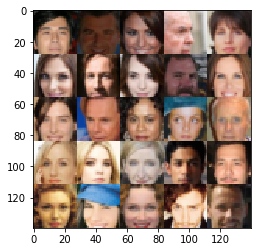

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='r_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return r_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(0.01 * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(0.01 * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(0.01 * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 3*3*512)
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(0.01 * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=4, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(0.01 * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='valid')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(0.01 * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 20
    show_step = 100
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = 2*batch_images
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step: {}:".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step: 20: Discriminator Loss: 0.7359... Generator Loss: 0.7678
Epoch 1/2... Step: 40: Discriminator Loss: 0.4720... Generator Loss: 1.2418
Epoch 1/2... Step: 60: Discriminator Loss: 1.6236... Generator Loss: 0.2364
Epoch 1/2... Step: 80: Discriminator Loss: 0.3588... Generator Loss: 1.6404
Epoch 1/2... Step: 100: Discriminator Loss: 0.3127... Generator Loss: 1.5927


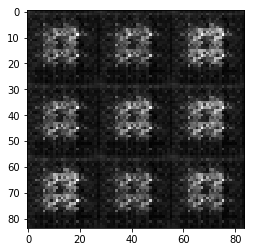

Epoch 1/2... Step: 120: Discriminator Loss: 0.0982... Generator Loss: 3.1477
Epoch 1/2... Step: 140: Discriminator Loss: 0.3347... Generator Loss: 1.4794
Epoch 1/2... Step: 160: Discriminator Loss: 0.2228... Generator Loss: 2.3179
Epoch 1/2... Step: 180: Discriminator Loss: 0.2710... Generator Loss: 2.5036
Epoch 1/2... Step: 200: Discriminator Loss: 0.3229... Generator Loss: 1.8467


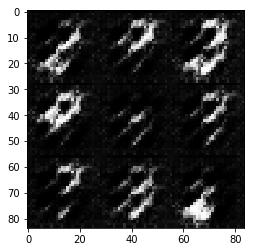

Epoch 1/2... Step: 220: Discriminator Loss: 0.2818... Generator Loss: 2.0691
Epoch 1/2... Step: 240: Discriminator Loss: 0.3120... Generator Loss: 2.5687
Epoch 1/2... Step: 260: Discriminator Loss: 0.9967... Generator Loss: 0.7512
Epoch 1/2... Step: 280: Discriminator Loss: 0.5221... Generator Loss: 1.4256
Epoch 1/2... Step: 300: Discriminator Loss: 0.6726... Generator Loss: 1.1363


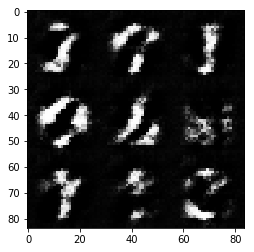

Epoch 1/2... Step: 320: Discriminator Loss: 0.4725... Generator Loss: 1.8216
Epoch 1/2... Step: 340: Discriminator Loss: 0.6523... Generator Loss: 1.2355
Epoch 1/2... Step: 360: Discriminator Loss: 0.9792... Generator Loss: 3.6120
Epoch 1/2... Step: 380: Discriminator Loss: 0.7780... Generator Loss: 3.1476
Epoch 1/2... Step: 400: Discriminator Loss: 0.7189... Generator Loss: 1.3246


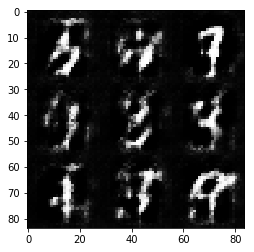

Epoch 1/2... Step: 420: Discriminator Loss: 0.6757... Generator Loss: 2.2600
Epoch 1/2... Step: 440: Discriminator Loss: 0.9412... Generator Loss: 0.7350
Epoch 1/2... Step: 460: Discriminator Loss: 0.9251... Generator Loss: 0.7547
Epoch 1/2... Step: 480: Discriminator Loss: 1.5834... Generator Loss: 0.3424
Epoch 1/2... Step: 500: Discriminator Loss: 1.2504... Generator Loss: 0.4407


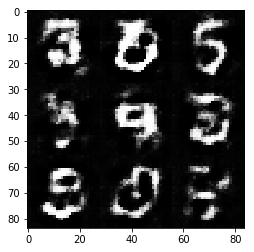

Epoch 1/2... Step: 520: Discriminator Loss: 1.3048... Generator Loss: 0.4380
Epoch 1/2... Step: 540: Discriminator Loss: 0.8067... Generator Loss: 1.0921
Epoch 1/2... Step: 560: Discriminator Loss: 1.1833... Generator Loss: 0.5396
Epoch 1/2... Step: 580: Discriminator Loss: 0.6531... Generator Loss: 1.6729
Epoch 1/2... Step: 600: Discriminator Loss: 1.1348... Generator Loss: 0.5052


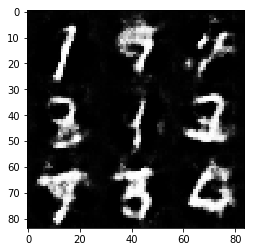

Epoch 1/2... Step: 620: Discriminator Loss: 1.0830... Generator Loss: 0.6185
Epoch 1/2... Step: 640: Discriminator Loss: 1.6632... Generator Loss: 0.2804
Epoch 1/2... Step: 660: Discriminator Loss: 1.1219... Generator Loss: 0.5231
Epoch 1/2... Step: 680: Discriminator Loss: 0.9043... Generator Loss: 2.0698
Epoch 1/2... Step: 700: Discriminator Loss: 0.5500... Generator Loss: 1.2775


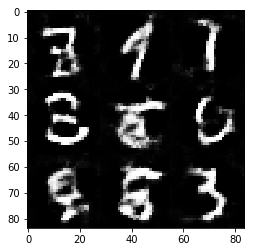

Epoch 1/2... Step: 720: Discriminator Loss: 0.7034... Generator Loss: 1.4199
Epoch 1/2... Step: 740: Discriminator Loss: 1.0245... Generator Loss: 0.6654
Epoch 1/2... Step: 760: Discriminator Loss: 1.1427... Generator Loss: 0.4978
Epoch 1/2... Step: 780: Discriminator Loss: 1.2462... Generator Loss: 0.4391
Epoch 1/2... Step: 800: Discriminator Loss: 1.0765... Generator Loss: 0.6021


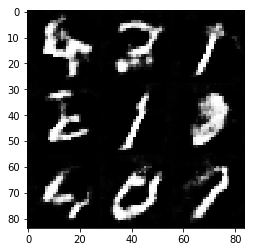

Epoch 1/2... Step: 820: Discriminator Loss: 1.1552... Generator Loss: 0.5580
Epoch 1/2... Step: 840: Discriminator Loss: 1.4062... Generator Loss: 0.3920
Epoch 1/2... Step: 860: Discriminator Loss: 0.8853... Generator Loss: 0.8577
Epoch 1/2... Step: 880: Discriminator Loss: 0.7108... Generator Loss: 1.1075
Epoch 1/2... Step: 900: Discriminator Loss: 1.1927... Generator Loss: 0.4805


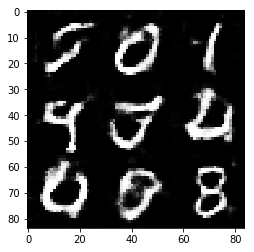

Epoch 1/2... Step: 920: Discriminator Loss: 0.6857... Generator Loss: 1.0127
Epoch 2/2... Step: 940: Discriminator Loss: 0.9503... Generator Loss: 0.6985
Epoch 2/2... Step: 960: Discriminator Loss: 1.0624... Generator Loss: 0.5713
Epoch 2/2... Step: 980: Discriminator Loss: 0.9058... Generator Loss: 0.7592
Epoch 2/2... Step: 1000: Discriminator Loss: 0.6713... Generator Loss: 1.3173


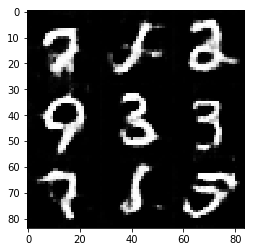

Epoch 2/2... Step: 1020: Discriminator Loss: 0.6652... Generator Loss: 2.0368
Epoch 2/2... Step: 1040: Discriminator Loss: 0.8084... Generator Loss: 0.9094
Epoch 2/2... Step: 1060: Discriminator Loss: 0.8424... Generator Loss: 0.9366
Epoch 2/2... Step: 1080: Discriminator Loss: 1.1401... Generator Loss: 0.5413
Epoch 2/2... Step: 1100: Discriminator Loss: 1.2323... Generator Loss: 3.0230


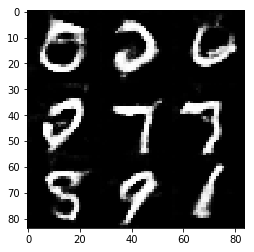

Epoch 2/2... Step: 1120: Discriminator Loss: 1.0245... Generator Loss: 0.6376
Epoch 2/2... Step: 1140: Discriminator Loss: 1.5468... Generator Loss: 0.3458
Epoch 2/2... Step: 1160: Discriminator Loss: 0.6386... Generator Loss: 1.1752
Epoch 2/2... Step: 1180: Discriminator Loss: 0.8849... Generator Loss: 0.8411
Epoch 2/2... Step: 1200: Discriminator Loss: 0.7212... Generator Loss: 1.0246


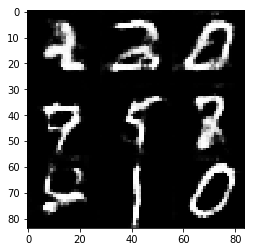

Epoch 2/2... Step: 1220: Discriminator Loss: 0.6955... Generator Loss: 0.9773
Epoch 2/2... Step: 1240: Discriminator Loss: 1.8725... Generator Loss: 0.2402
Epoch 2/2... Step: 1260: Discriminator Loss: 0.6504... Generator Loss: 1.2933
Epoch 2/2... Step: 1280: Discriminator Loss: 0.9025... Generator Loss: 0.6986
Epoch 2/2... Step: 1300: Discriminator Loss: 0.8641... Generator Loss: 0.7709


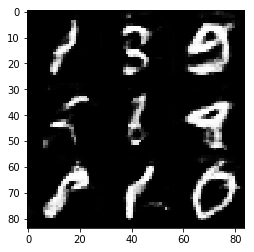

Epoch 2/2... Step: 1320: Discriminator Loss: 1.6070... Generator Loss: 0.4100
Epoch 2/2... Step: 1340: Discriminator Loss: 1.4842... Generator Loss: 3.0589
Epoch 2/2... Step: 1360: Discriminator Loss: 0.8586... Generator Loss: 0.8644
Epoch 2/2... Step: 1380: Discriminator Loss: 0.5426... Generator Loss: 2.0953
Epoch 2/2... Step: 1400: Discriminator Loss: 0.8855... Generator Loss: 0.7301


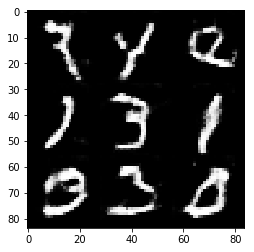

Epoch 2/2... Step: 1420: Discriminator Loss: 0.9949... Generator Loss: 0.6689
Epoch 2/2... Step: 1440: Discriminator Loss: 1.6787... Generator Loss: 0.3018
Epoch 2/2... Step: 1460: Discriminator Loss: 0.5787... Generator Loss: 1.1448
Epoch 2/2... Step: 1480: Discriminator Loss: 0.6138... Generator Loss: 1.0530
Epoch 2/2... Step: 1500: Discriminator Loss: 0.7925... Generator Loss: 2.6499


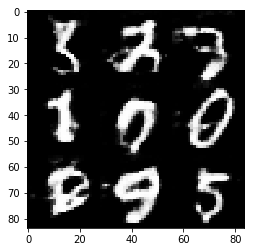

Epoch 2/2... Step: 1520: Discriminator Loss: 0.4727... Generator Loss: 1.7117
Epoch 2/2... Step: 1540: Discriminator Loss: 0.5967... Generator Loss: 1.1337
Epoch 2/2... Step: 1560: Discriminator Loss: 0.5399... Generator Loss: 1.2866
Epoch 2/2... Step: 1580: Discriminator Loss: 0.9482... Generator Loss: 2.7311
Epoch 2/2... Step: 1600: Discriminator Loss: 0.5558... Generator Loss: 1.2081


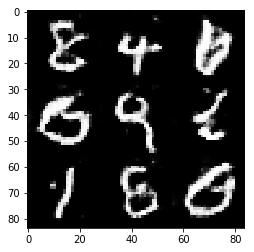

Epoch 2/2... Step: 1620: Discriminator Loss: 0.7447... Generator Loss: 0.9872
Epoch 2/2... Step: 1640: Discriminator Loss: 0.5554... Generator Loss: 1.8240
Epoch 2/2... Step: 1660: Discriminator Loss: 0.8131... Generator Loss: 0.8585
Epoch 2/2... Step: 1680: Discriminator Loss: 0.8208... Generator Loss: 0.7963
Epoch 2/2... Step: 1700: Discriminator Loss: 0.6242... Generator Loss: 1.0546


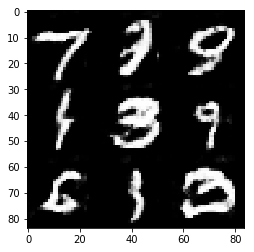

Epoch 2/2... Step: 1720: Discriminator Loss: 0.4454... Generator Loss: 1.5507
Epoch 2/2... Step: 1740: Discriminator Loss: 1.4927... Generator Loss: 0.3586
Epoch 2/2... Step: 1760: Discriminator Loss: 0.4734... Generator Loss: 1.3557
Epoch 2/2... Step: 1780: Discriminator Loss: 0.8056... Generator Loss: 0.8169
Epoch 2/2... Step: 1800: Discriminator Loss: 0.7076... Generator Loss: 1.0118


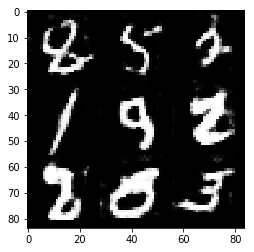

Epoch 2/2... Step: 1820: Discriminator Loss: 1.2596... Generator Loss: 0.5364
Epoch 2/2... Step: 1840: Discriminator Loss: 0.4837... Generator Loss: 1.5303
Epoch 2/2... Step: 1860: Discriminator Loss: 1.6340... Generator Loss: 0.3776


In [40]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step: 20: Discriminator Loss: 0.2240... Generator Loss: 5.7616
Epoch 1/1... Step: 40: Discriminator Loss: 0.3596... Generator Loss: 3.5700
Epoch 1/1... Step: 60: Discriminator Loss: 0.0928... Generator Loss: 4.8193
Epoch 1/1... Step: 80: Discriminator Loss: 0.1917... Generator Loss: 1.9368
Epoch 1/1... Step: 100: Discriminator Loss: 0.3833... Generator Loss: 1.4671


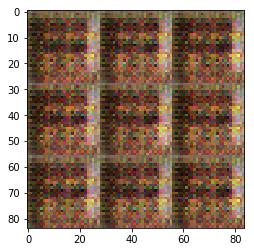

Epoch 1/1... Step: 120: Discriminator Loss: 1.5123... Generator Loss: 0.3568
Epoch 1/1... Step: 140: Discriminator Loss: 0.8319... Generator Loss: 0.8338
Epoch 1/1... Step: 160: Discriminator Loss: 0.9042... Generator Loss: 0.7698
Epoch 1/1... Step: 180: Discriminator Loss: 0.4595... Generator Loss: 1.7565
Epoch 1/1... Step: 200: Discriminator Loss: 0.6957... Generator Loss: 1.2731


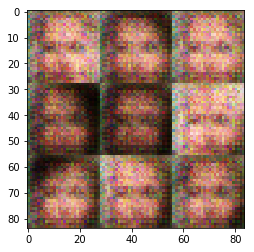

Epoch 1/1... Step: 220: Discriminator Loss: 1.1051... Generator Loss: 0.7621
Epoch 1/1... Step: 240: Discriminator Loss: 0.5966... Generator Loss: 2.8159
Epoch 1/1... Step: 260: Discriminator Loss: 0.9341... Generator Loss: 0.8665
Epoch 1/1... Step: 280: Discriminator Loss: 0.6365... Generator Loss: 3.6868
Epoch 1/1... Step: 300: Discriminator Loss: 0.5326... Generator Loss: 3.1276


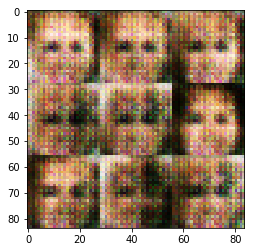

Epoch 1/1... Step: 320: Discriminator Loss: 0.9845... Generator Loss: 0.7329
Epoch 1/1... Step: 340: Discriminator Loss: 0.5546... Generator Loss: 1.8826
Epoch 1/1... Step: 360: Discriminator Loss: 0.4016... Generator Loss: 1.6749
Epoch 1/1... Step: 380: Discriminator Loss: 1.1708... Generator Loss: 0.5402
Epoch 1/1... Step: 400: Discriminator Loss: 0.4280... Generator Loss: 1.8814


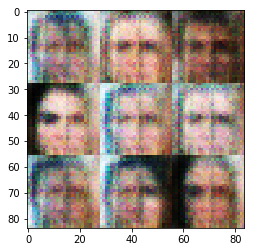

Epoch 1/1... Step: 420: Discriminator Loss: 0.4889... Generator Loss: 1.6825
Epoch 1/1... Step: 440: Discriminator Loss: 0.4234... Generator Loss: 1.5316
Epoch 1/1... Step: 460: Discriminator Loss: 0.5041... Generator Loss: 1.5664
Epoch 1/1... Step: 480: Discriminator Loss: 0.7382... Generator Loss: 1.0300
Epoch 1/1... Step: 500: Discriminator Loss: 0.3658... Generator Loss: 1.9217


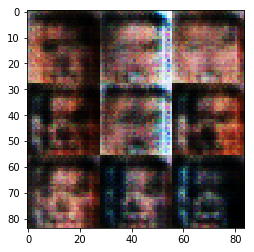

Epoch 1/1... Step: 520: Discriminator Loss: 0.6165... Generator Loss: 1.8865
Epoch 1/1... Step: 540: Discriminator Loss: 0.9217... Generator Loss: 0.7215
Epoch 1/1... Step: 560: Discriminator Loss: 0.4240... Generator Loss: 1.8789
Epoch 1/1... Step: 580: Discriminator Loss: 0.5533... Generator Loss: 2.8599
Epoch 1/1... Step: 600: Discriminator Loss: 0.8205... Generator Loss: 2.4505


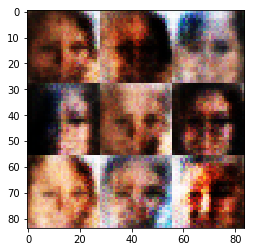

Epoch 1/1... Step: 620: Discriminator Loss: 0.5546... Generator Loss: 1.7265
Epoch 1/1... Step: 640: Discriminator Loss: 0.4418... Generator Loss: 1.8064
Epoch 1/1... Step: 660: Discriminator Loss: 1.2983... Generator Loss: 0.4808
Epoch 1/1... Step: 680: Discriminator Loss: 1.1456... Generator Loss: 0.5262
Epoch 1/1... Step: 700: Discriminator Loss: 1.5924... Generator Loss: 0.3350


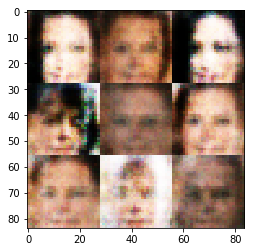

Epoch 1/1... Step: 720: Discriminator Loss: 0.6703... Generator Loss: 1.3228
Epoch 1/1... Step: 740: Discriminator Loss: 1.6179... Generator Loss: 0.2830
Epoch 1/1... Step: 760: Discriminator Loss: 1.2795... Generator Loss: 4.0677
Epoch 1/1... Step: 780: Discriminator Loss: 0.5627... Generator Loss: 1.4384
Epoch 1/1... Step: 800: Discriminator Loss: 0.4642... Generator Loss: 2.4170


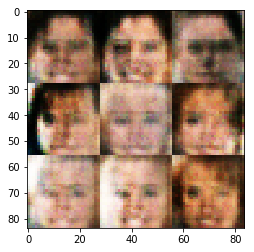

Epoch 1/1... Step: 820: Discriminator Loss: 0.7045... Generator Loss: 2.9232
Epoch 1/1... Step: 840: Discriminator Loss: 0.3709... Generator Loss: 1.9547
Epoch 1/1... Step: 860: Discriminator Loss: 0.8263... Generator Loss: 0.7320
Epoch 1/1... Step: 880: Discriminator Loss: 0.5868... Generator Loss: 1.3421
Epoch 1/1... Step: 900: Discriminator Loss: 0.7838... Generator Loss: 0.9761


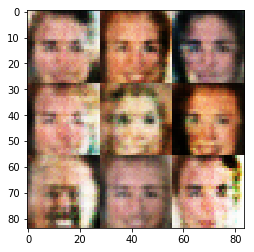

Epoch 1/1... Step: 920: Discriminator Loss: 0.6821... Generator Loss: 1.6436
Epoch 1/1... Step: 940: Discriminator Loss: 0.4950... Generator Loss: 1.5438
Epoch 1/1... Step: 960: Discriminator Loss: 1.2693... Generator Loss: 3.3976
Epoch 1/1... Step: 980: Discriminator Loss: 0.5522... Generator Loss: 1.3893
Epoch 1/1... Step: 1000: Discriminator Loss: 0.6843... Generator Loss: 2.1772


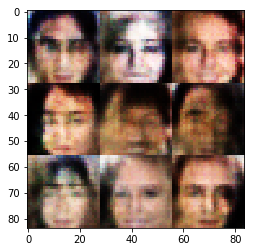

Epoch 1/1... Step: 1020: Discriminator Loss: 0.7218... Generator Loss: 0.9587
Epoch 1/1... Step: 1040: Discriminator Loss: 0.4310... Generator Loss: 1.9824
Epoch 1/1... Step: 1060: Discriminator Loss: 0.9005... Generator Loss: 0.8150
Epoch 1/1... Step: 1080: Discriminator Loss: 0.5845... Generator Loss: 1.5345
Epoch 1/1... Step: 1100: Discriminator Loss: 0.7107... Generator Loss: 2.2787


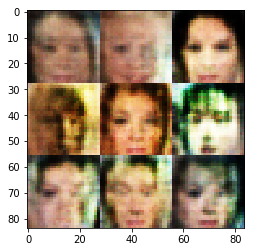

Epoch 1/1... Step: 1120: Discriminator Loss: 0.8360... Generator Loss: 1.7706
Epoch 1/1... Step: 1140: Discriminator Loss: 0.5669... Generator Loss: 1.5772
Epoch 1/1... Step: 1160: Discriminator Loss: 1.0743... Generator Loss: 0.5970
Epoch 1/1... Step: 1180: Discriminator Loss: 0.8857... Generator Loss: 0.8282
Epoch 1/1... Step: 1200: Discriminator Loss: 0.6399... Generator Loss: 2.3497


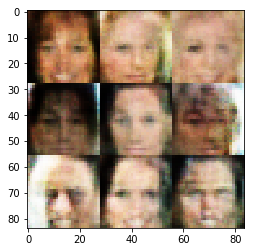

Epoch 1/1... Step: 1220: Discriminator Loss: 0.7907... Generator Loss: 2.2723
Epoch 1/1... Step: 1240: Discriminator Loss: 1.3731... Generator Loss: 0.4061
Epoch 1/1... Step: 1260: Discriminator Loss: 0.6901... Generator Loss: 1.6124
Epoch 1/1... Step: 1280: Discriminator Loss: 1.5180... Generator Loss: 0.3270
Epoch 1/1... Step: 1300: Discriminator Loss: 0.8422... Generator Loss: 1.0808


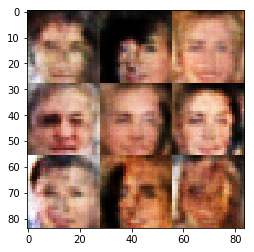

Epoch 1/1... Step: 1320: Discriminator Loss: 0.7519... Generator Loss: 1.1197
Epoch 1/1... Step: 1340: Discriminator Loss: 0.7486... Generator Loss: 1.3598
Epoch 1/1... Step: 1360: Discriminator Loss: 0.8716... Generator Loss: 0.8267
Epoch 1/1... Step: 1380: Discriminator Loss: 0.6560... Generator Loss: 1.0415
Epoch 1/1... Step: 1400: Discriminator Loss: 0.8623... Generator Loss: 0.8055


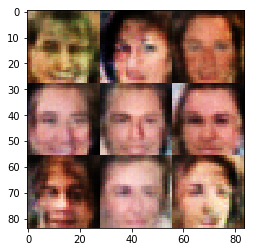

Epoch 1/1... Step: 1420: Discriminator Loss: 0.8374... Generator Loss: 0.7800
Epoch 1/1... Step: 1440: Discriminator Loss: 0.9890... Generator Loss: 0.7253
Epoch 1/1... Step: 1460: Discriminator Loss: 0.8361... Generator Loss: 0.8428
Epoch 1/1... Step: 1480: Discriminator Loss: 1.1274... Generator Loss: 0.5308
Epoch 1/1... Step: 1500: Discriminator Loss: 0.6265... Generator Loss: 1.4848


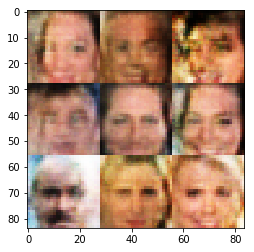

Epoch 1/1... Step: 1520: Discriminator Loss: 0.6944... Generator Loss: 1.6989
Epoch 1/1... Step: 1540: Discriminator Loss: 0.8010... Generator Loss: 0.9952
Epoch 1/1... Step: 1560: Discriminator Loss: 1.1753... Generator Loss: 0.4877
Epoch 1/1... Step: 1580: Discriminator Loss: 1.1123... Generator Loss: 0.4979
Epoch 1/1... Step: 1600: Discriminator Loss: 0.9474... Generator Loss: 0.6723


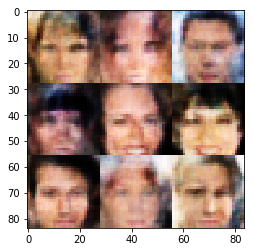

Epoch 1/1... Step: 1620: Discriminator Loss: 0.7986... Generator Loss: 1.3191
Epoch 1/1... Step: 1640: Discriminator Loss: 0.6994... Generator Loss: 1.4350
Epoch 1/1... Step: 1660: Discriminator Loss: 1.0266... Generator Loss: 0.7161
Epoch 1/1... Step: 1680: Discriminator Loss: 1.2377... Generator Loss: 0.4287
Epoch 1/1... Step: 1700: Discriminator Loss: 0.7580... Generator Loss: 1.2274


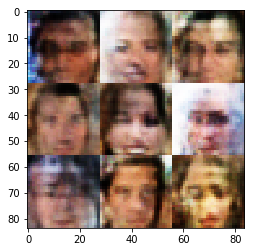

Epoch 1/1... Step: 1720: Discriminator Loss: 0.9835... Generator Loss: 1.7211
Epoch 1/1... Step: 1740: Discriminator Loss: 0.6732... Generator Loss: 1.5116
Epoch 1/1... Step: 1760: Discriminator Loss: 0.7757... Generator Loss: 1.0934
Epoch 1/1... Step: 1780: Discriminator Loss: 0.8812... Generator Loss: 1.1092
Epoch 1/1... Step: 1800: Discriminator Loss: 0.8457... Generator Loss: 0.9380


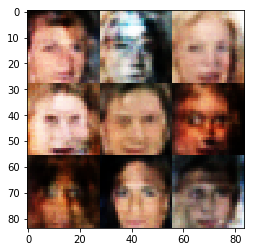

Epoch 1/1... Step: 1820: Discriminator Loss: 0.8586... Generator Loss: 1.3452
Epoch 1/1... Step: 1840: Discriminator Loss: 1.2337... Generator Loss: 2.5792
Epoch 1/1... Step: 1860: Discriminator Loss: 1.0664... Generator Loss: 1.4570
Epoch 1/1... Step: 1880: Discriminator Loss: 1.2524... Generator Loss: 0.4797
Epoch 1/1... Step: 1900: Discriminator Loss: 0.8179... Generator Loss: 1.1737


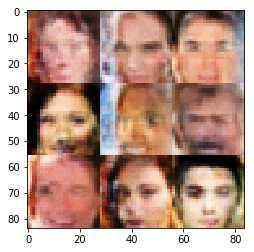

Epoch 1/1... Step: 1920: Discriminator Loss: 1.1295... Generator Loss: 0.5673
Epoch 1/1... Step: 1940: Discriminator Loss: 1.2528... Generator Loss: 0.4249
Epoch 1/1... Step: 1960: Discriminator Loss: 0.8521... Generator Loss: 0.7329
Epoch 1/1... Step: 1980: Discriminator Loss: 1.1507... Generator Loss: 0.5657
Epoch 1/1... Step: 2000: Discriminator Loss: 0.9277... Generator Loss: 0.7139


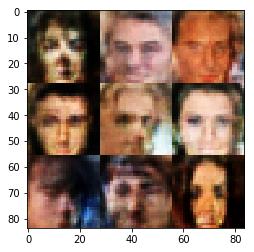

Epoch 1/1... Step: 2020: Discriminator Loss: 1.1293... Generator Loss: 0.5176
Epoch 1/1... Step: 2040: Discriminator Loss: 0.9799... Generator Loss: 0.6905
Epoch 1/1... Step: 2060: Discriminator Loss: 0.8351... Generator Loss: 1.2805
Epoch 1/1... Step: 2080: Discriminator Loss: 0.6960... Generator Loss: 1.6911
Epoch 1/1... Step: 2100: Discriminator Loss: 1.1130... Generator Loss: 0.5561


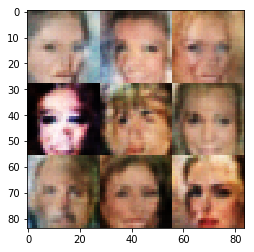

Epoch 1/1... Step: 2120: Discriminator Loss: 1.2164... Generator Loss: 0.4744
Epoch 1/1... Step: 2140: Discriminator Loss: 1.5257... Generator Loss: 0.3431
Epoch 1/1... Step: 2160: Discriminator Loss: 0.7532... Generator Loss: 1.2974
Epoch 1/1... Step: 2180: Discriminator Loss: 0.7398... Generator Loss: 1.0238
Epoch 1/1... Step: 2200: Discriminator Loss: 0.8764... Generator Loss: 1.1498


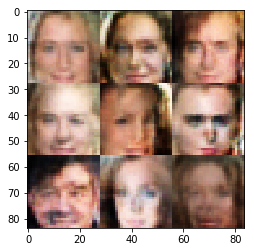

Epoch 1/1... Step: 2220: Discriminator Loss: 1.0904... Generator Loss: 1.9799
Epoch 1/1... Step: 2240: Discriminator Loss: 1.3767... Generator Loss: 0.3753
Epoch 1/1... Step: 2260: Discriminator Loss: 1.1673... Generator Loss: 0.5104
Epoch 1/1... Step: 2280: Discriminator Loss: 1.3790... Generator Loss: 0.3762
Epoch 1/1... Step: 2300: Discriminator Loss: 0.8764... Generator Loss: 0.8723


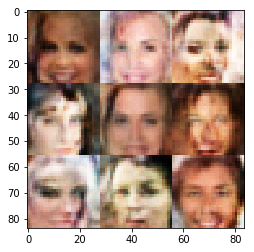

Epoch 1/1... Step: 2320: Discriminator Loss: 0.9406... Generator Loss: 1.2845
Epoch 1/1... Step: 2340: Discriminator Loss: 1.0584... Generator Loss: 1.7471
Epoch 1/1... Step: 2360: Discriminator Loss: 1.5215... Generator Loss: 0.3316
Epoch 1/1... Step: 2380: Discriminator Loss: 1.0374... Generator Loss: 2.1163
Epoch 1/1... Step: 2400: Discriminator Loss: 0.8023... Generator Loss: 1.3542


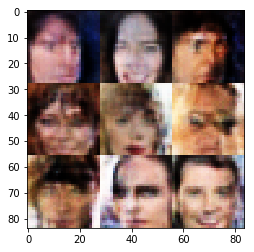

Epoch 1/1... Step: 2420: Discriminator Loss: 1.2532... Generator Loss: 0.4470
Epoch 1/1... Step: 2440: Discriminator Loss: 1.0206... Generator Loss: 1.3358
Epoch 1/1... Step: 2460: Discriminator Loss: 1.5574... Generator Loss: 0.3006
Epoch 1/1... Step: 2480: Discriminator Loss: 0.8169... Generator Loss: 1.1846
Epoch 1/1... Step: 2500: Discriminator Loss: 0.9904... Generator Loss: 1.3403


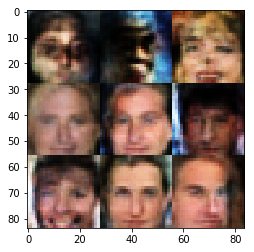

Epoch 1/1... Step: 2520: Discriminator Loss: 0.8937... Generator Loss: 0.8641
Epoch 1/1... Step: 2540: Discriminator Loss: 0.8171... Generator Loss: 1.6859
Epoch 1/1... Step: 2560: Discriminator Loss: 1.3175... Generator Loss: 0.4126
Epoch 1/1... Step: 2580: Discriminator Loss: 1.2213... Generator Loss: 0.4482
Epoch 1/1... Step: 2600: Discriminator Loss: 1.2220... Generator Loss: 2.5619


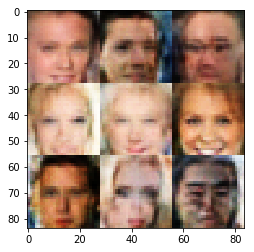

Epoch 1/1... Step: 2620: Discriminator Loss: 0.8568... Generator Loss: 1.0078
Epoch 1/1... Step: 2640: Discriminator Loss: 1.0124... Generator Loss: 1.1364
Epoch 1/1... Step: 2660: Discriminator Loss: 1.2874... Generator Loss: 0.4208
Epoch 1/1... Step: 2680: Discriminator Loss: 0.9171... Generator Loss: 1.1798
Epoch 1/1... Step: 2700: Discriminator Loss: 1.0704... Generator Loss: 1.9927


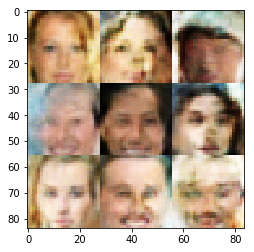

Epoch 1/1... Step: 2720: Discriminator Loss: 1.6342... Generator Loss: 0.2639
Epoch 1/1... Step: 2740: Discriminator Loss: 0.6334... Generator Loss: 1.1695
Epoch 1/1... Step: 2760: Discriminator Loss: 1.0079... Generator Loss: 0.7131
Epoch 1/1... Step: 2780: Discriminator Loss: 1.5251... Generator Loss: 0.3154
Epoch 1/1... Step: 2800: Discriminator Loss: 0.8122... Generator Loss: 1.2691


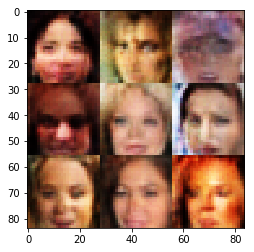

Epoch 1/1... Step: 2820: Discriminator Loss: 1.4032... Generator Loss: 0.3531
Epoch 1/1... Step: 2840: Discriminator Loss: 1.0515... Generator Loss: 0.6460
Epoch 1/1... Step: 2860: Discriminator Loss: 1.9120... Generator Loss: 0.2034
Epoch 1/1... Step: 2880: Discriminator Loss: 0.7815... Generator Loss: 1.0016
Epoch 1/1... Step: 2900: Discriminator Loss: 0.7603... Generator Loss: 1.5402


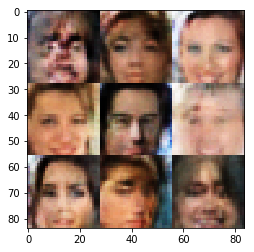

Epoch 1/1... Step: 2920: Discriminator Loss: 1.2882... Generator Loss: 2.9041
Epoch 1/1... Step: 2940: Discriminator Loss: 1.0548... Generator Loss: 0.6313
Epoch 1/1... Step: 2960: Discriminator Loss: 1.7216... Generator Loss: 0.2465
Epoch 1/1... Step: 2980: Discriminator Loss: 0.7985... Generator Loss: 0.8941
Epoch 1/1... Step: 3000: Discriminator Loss: 1.4760... Generator Loss: 0.3492


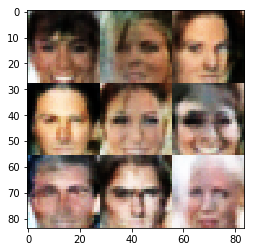

Epoch 1/1... Step: 3020: Discriminator Loss: 0.9900... Generator Loss: 0.8496
Epoch 1/1... Step: 3040: Discriminator Loss: 1.3642... Generator Loss: 0.4252
Epoch 1/1... Step: 3060: Discriminator Loss: 1.8735... Generator Loss: 0.2140
Epoch 1/1... Step: 3080: Discriminator Loss: 0.8210... Generator Loss: 0.8814
Epoch 1/1... Step: 3100: Discriminator Loss: 0.6051... Generator Loss: 1.1401


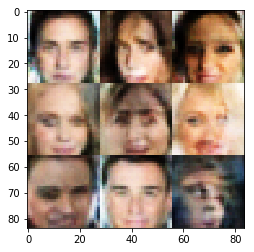

Epoch 1/1... Step: 3120: Discriminator Loss: 0.9913... Generator Loss: 0.9699
Epoch 1/1... Step: 3140: Discriminator Loss: 0.7746... Generator Loss: 1.5169
Epoch 1/1... Step: 3160: Discriminator Loss: 0.5759... Generator Loss: 1.7846


In [41]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.